In [164]:
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
from scipy.signal import lfilter, butter

# Set the sample rate (in Hz)
sample_rate = 44100

# Set the frequency of the note (in Hz)
frequency = 440  # A4

# Set the duration of the note (in seconds)
duration = 1

# Create an empty array to hold the audio samples
input_signal = np.zeros(int(duration * sample_rate))

# Add sine waves at the fundamental frequency and various harmonics to the signal
for harmonic in range(1, 6):
    input_signal += np.sin(2 * np.pi * frequency * harmonic * np.arange(len(input_signal)) / sample_rate)

# Normalize the signal
input_signal /= np.max(np.abs(input_signal))


def apply_lowpass_filter_sweep(input_signal, timbre):
    # Create a low-pass filter with a variable cutoff frequency
    cutoff_frequency = 2000 * timbre  # Range: 0-2000 Hz
    b, a = butter(4, cutoff_frequency / (44100 / 2), 'low')

    # Apply the filter to the input signal
    output_signal = lfilter(b, a, input_signal)

    return output_signal

def apply_highpass_filter_sweep(input_signal, timbre):
    # Create a high-pass filter with a variable cutoff frequency
    cutoff_frequency = 2000 * (1 - timbre)  # Range: 2000-0 Hz
    b, a = butter(4, cutoff_frequency / (44100 / 2), 'high')

    # Apply the filter to the input signal
    output_signal = lfilter(b, a, input_signal)

    return output_signal



def apply_band_pass_filter(input_signal, timbre):
    # Calculate the cutoff frequencies based on the timbre parameter
    lower_cutoff = 100 + 900 * timbre  # Range: 100-1000 Hz
    upper_cutoff = 1000 + 9000 * timbre  # Range: 1000-10000 Hz
    cutoff_frequencies = (lower_cutoff, upper_cutoff)

    # Create a band-pass filter with the calculated cutoff frequencies
    b, a = butter(4, cutoff_frequencies / (44100 / 2), 'band')

    # Apply the filter to the input signal
    output_signal = lfilter(b, a, input_signal)

    return output_signal
    

def apply_envelope_shaping(input_signal, timbre):
    # Create an envelope with a variable attack and decay time
    attack_time = 0.01 * (1 - timbre)  # Range: 0.01-0 seconds
    decay_time = 0.01 * timbre  # Range: 0-0.01 seconds
    envelope = np.ones_like(input_signal)
    envelope[:int(attack_time * 44100)] = np.linspace(0, 1, int(attack_time * 44100))
    envelope[-int(decay_time * 44100):] = np.linspace(1, 0, int(decay_time * 44100))

    # Apply the envelope to the input signal
    output_signal = input_signal * envelope

    return output_signal


def apply_pitch_modulation(input_signal, timbre):
    # Create an LFO with a variable frequency
    lfo_frequency = 10 * timbre  # Range: 0-10 Hz
    lfo = np.sin(2 * np.pi * np.arange(len(input_signal)) * lfo_frequency / 44100)

    # Use the LFO to modulate the pitch of the input signal
    output_signal = input_signal * (1 + lfo)

    return output_signal


def apply_timbre_modulation(input_signal, timbre):
    # Create an LFO with a variable frequency and depth
    lfo_frequency = 10 * timbre  # Range: 0-10 Hz
    lfo_depth = 0.5 * timbre  # Range: 0-0.5
    lfo = np.sin(2 * np.pi * np.arange(len(input_signal)) * lfo_frequency / 44100)

    # Use the LFO to modulate the timbre of the input signal
    output_signal = input_signal * (1 + lfo_depth * lfo)

    return output_signal

def apply_distortion(input_signal, timbre):
    # Calculate the distortion threshold based on the timbre parameter
    threshold = 0.5 + 0.5 * timbre  # Range: 0.5-1.0
    
    # Apply distortion to the input signal by clipping it above the calculated threshold
    output_signal = np.clip(input_signal, -threshold, threshold)

    return output_signal

    

def play_sound(input_signal, sample_rate):
    # Set the audio device to use
    sd.default.device = sd.query_devices()[0]['name']

    # Play the sound
    sd.play(input_signal, sample_rate)

    # Wait until the sound is finished playing
    sd.wait()


def apply_sampling(input_signal, timbre):
    # Calculate the new sample rate based on the timbre parameter
    sample_rate = 44100 + 90000 * timbre  # Range: 44100-1341000 Hz

    # Resample the input signal at the new sample rate
    output_signal = np.resize(input_signal, int(len(input_signal) * sample_rate / 44100))

    return output_signal
    

def plot_signal(input_signal, sample_rate):
    # Get the time axis in seconds
    time = np.arange(len(input_signal)) / sample_rate

    # Plot the signal
    plt.plot(time, input_signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Signal')
    plt.show()


def play_and_plot(input_signal, sample_rate):
    play_sound(input_signal, sample_rate)

    input_signal_slice = input_signal[:int(sample_rate / 50)]
    plot_signal(input_signal_slice, sample_rate)
    



In [ ]:
import pyo

def apply_reverberation(input_signal, timbre):
    # Calculate the reverberation decay time and damping frequency based on the timbre parameter
    decay_time = 0.5 + 1.5 * timbre  # Range: 0.5-2.0 seconds
    damping_frequency = 1000 + 9000 * timbre  # Range: 1000-10000 Hz
    mix = 0.5 + 0.5 * timbre  # Range: 0.5-1.0

    # Create a pyo server and audio buffer to hold the input signal
    server = pyo.Server().boot()
    audio_buffer = pyo.Buffer(input_signal, 1, True)

    # Create a pyo reverb object with the calculated decay time and damping frequency
    reverb = pyo.Freeverb(audio_buffer, size=decay_time, damp=damping_frequency, bal=mix)

    # Start the server and let the reverb run for the duration of the input signal
    server.start()
    reverb.out()
    server.stop()

    # Get the output signal from the reverb object
    output_signal = reverb.getOutput()

    return output_signal


def apply_granular_synthesis(input_signal, timbre):
    # Calculate the grain size, grain rate, and pitch shift based on the timbre parameter
    grain_size = 0.1 + 0.9 * timbre  # Range: 0.1-1.0 seconds
    grain_rate = 10 + 90 * timbre  # Range: 10-100 grains per second
    pitch_shift = -1 + 2 * timbre  # Range: -1 to 1 semitones

    # Create a pyo server and audio buffer to hold the input signal
    server = pyo.Server().boot()
    audio_buffer = pyo.Buffer(input_signal, 1, True)

    # Create a pyo Granulator object with the calculated grain size, grain rate, and pitch shift
    granulator = pyo.Granulator(audio_buffer, grainsize=grain_size, rate=grain_rate, pitch=pitch_shift)

    # Start the server and let the granulator run for the duration of the input signal
    server.start()
    granulator.out()
    server.stop()

    # Get the output signal from the granulator object
    output_signal = granulator.getOutput()

    return output_signal

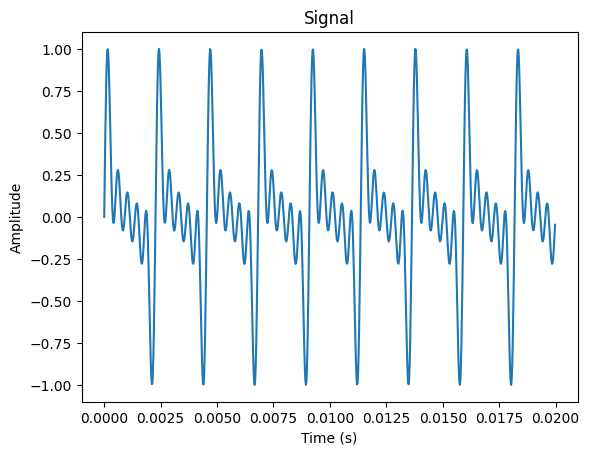

In [165]:
play_and_plot(input_signal, sample_rate)

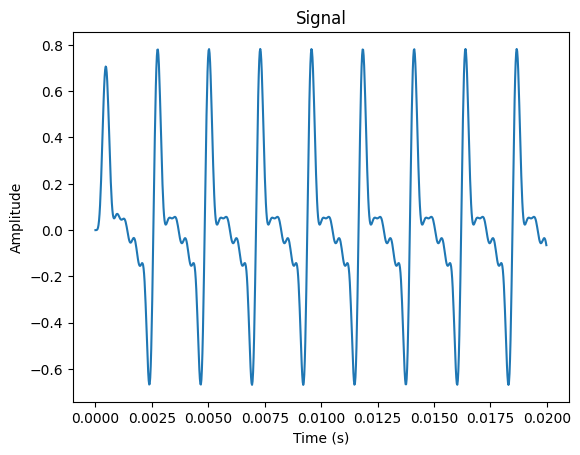

In [166]:
output_signal = apply_lowpass_filter_sweep(input_signal, 0.8)

play_and_plot(output_signal, sample_rate)

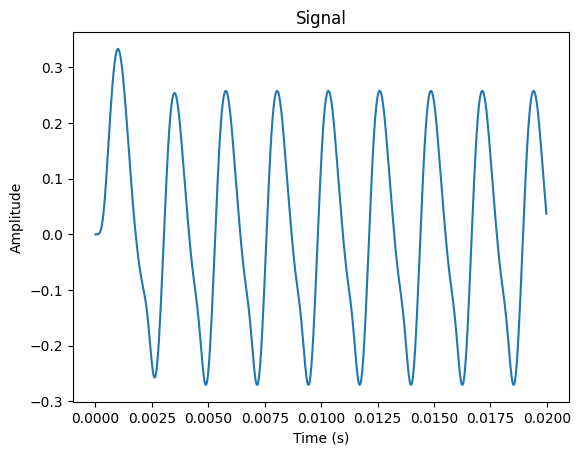

In [167]:
output_signal = apply_lowpass_filter_sweep(input_signal, 0.3)

play_and_plot(output_signal, sample_rate)

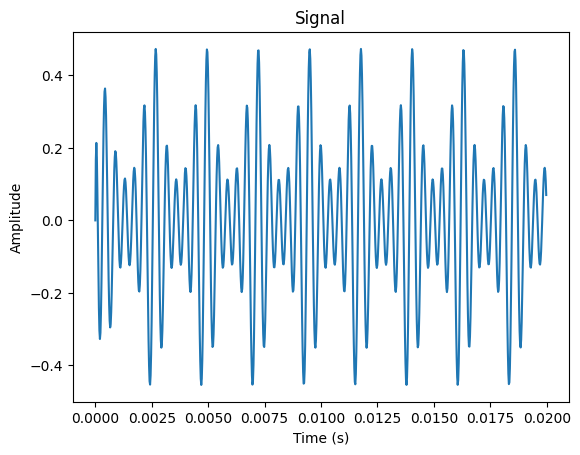

In [168]:
output_signal = apply_highpass_filter_sweep(input_signal, 0.1)

play_and_plot(output_signal, sample_rate)

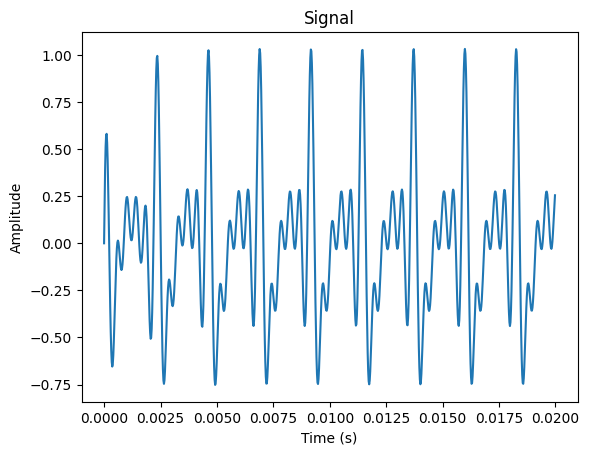

In [169]:
output_signal = apply_highpass_filter_sweep(input_signal, 0.8)

play_and_plot(output_signal, sample_rate)